# Exercise-2

> I will be using a different model `tf.keras.applications.efficientnet_v2` as the base model for training.

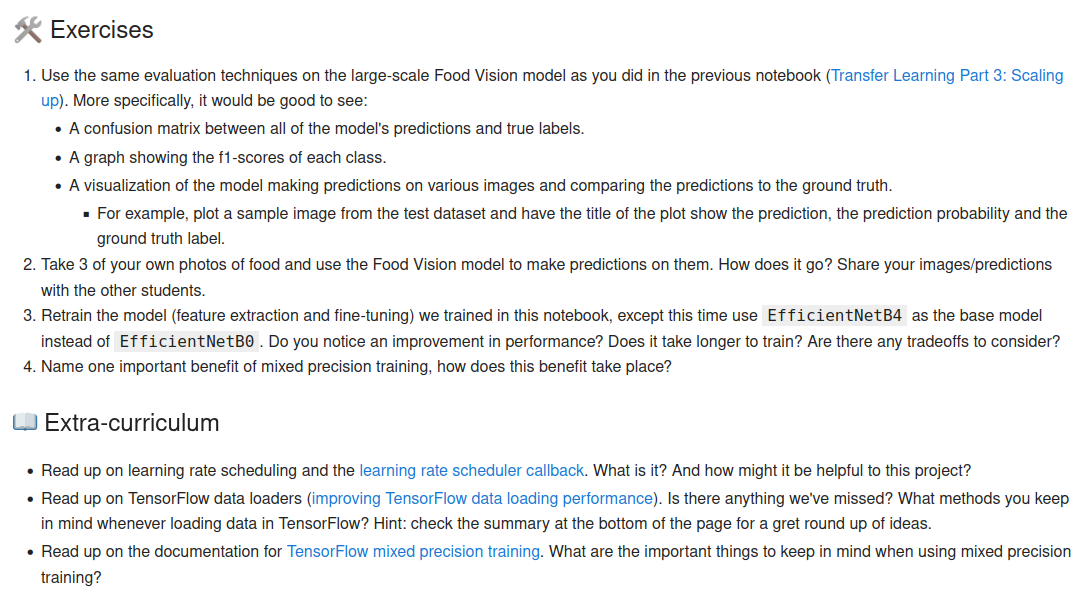

## Imports

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
import tensorflow_datasets as tfds
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import regularizers
from tensorflow.keras import mixed_precision

import os
import random
import itertools

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
%matplotlib inline

## Helper Function

In [2]:
!wget https://raw.githubusercontent.com/arghanath007/MachineLearning/main/Deep%20Learning/Transfer%20Learning/helper_functions.py

--2022-08-17 07:27:30--  https://raw.githubusercontent.com/arghanath007/MachineLearning/main/Deep%20Learning/Transfer%20Learning/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19296 (19K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  18.84K  --.-KB/s    in 0s      

2022-08-17 07:27:30 (84.9 MB/s) - ‘helper_functions.py’ saved [19296/19296]



In [3]:
from helper_functions import unzip_data, plot_loss_curves, compare_historys, create_data_augmented_layer_for_model, load_and_prep_image, make_confusion_matrix_for_larger_dataset

## Loading the dataset

In [4]:
(train_data, test_data), ds_info= tfds.load(name="food101", split=["train", "validation"], shuffle_files=False, as_supervised=True, with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/75750 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/food101/2.0.0.incomplete4CGCXR/food101-train.tfrecord*...:   0%|          | 0/…

Generating validation examples...:   0%|          | 0/25250 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/food101/2.0.0.incomplete4CGCXR/food101-validation.tfrecord*...:   0%|         …

Dataset food101 downloaded and prepared to ~/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [5]:
ds_info

tfds.core.DatasetInfo(
    name='food101',
    full_name='food101/2.0.0',
    description="""
    This dataset consists of 101 food categories, with 101'000 images. For each class, 250 manually reviewed test images are provided as well as 750 training images. On purpose, the training images were not cleaned, and thus still contain some amount of noise. This comes mostly in the form of intense colors and sometimes wrong labels. All images were rescaled to have a maximum side length of 512 pixels.
    """,
    homepage='https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/',
    data_path='~/tensorflow_datasets/food101/2.0.0',
    file_format=tfrecord,
    download_size=4.65 GiB,
    dataset_size=4.77 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo

In [6]:
class_names= ds_info.features['label'].names
len(class_names)

101

In [7]:
sample_1= train_data.take(5)
sample_1

<TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [8]:
for image, label in sample_1:
  print(f"""
  Image shape: {image.shape}
  Image dtype: {image.dtype}
  Target class or Label from Food101 (tensor form): {label}
  Class name (str form): {class_names[label.numpy()]}
        """)


  Image shape: (512, 512, 3)
  Image dtype: <dtype: 'uint8'>
  Target class or Label from Food101 (tensor form): 56
  Class name (str form): huevos_rancheros
        

  Image shape: (384, 512, 3)
  Image dtype: <dtype: 'uint8'>
  Target class or Label from Food101 (tensor form): 76
  Class name (str form): pizza
        

  Image shape: (512, 512, 3)
  Image dtype: <dtype: 'uint8'>
  Target class or Label from Food101 (tensor form): 21
  Class name (str form): chocolate_cake
        

  Image shape: (512, 512, 3)
  Image dtype: <dtype: 'uint8'>
  Target class or Label from Food101 (tensor form): 64
  Class name (str form): miso_soup
        

  Image shape: (512, 512, 3)
  Image dtype: <dtype: 'uint8'>
  Target class or Label from Food101 (tensor form): 10
  Class name (str form): bruschetta
        


In [9]:
image.shape

TensorShape([512, 512, 3])

## Plotting image from the dataset

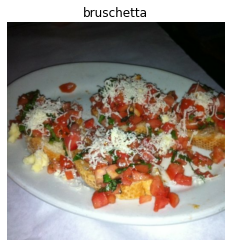

In [10]:
plt.imshow(image/255)
plt.title(class_names[label.numpy()])
plt.axis(False);

## Preprocessing Image Function

In [11]:
from helper_functions import preprocess_image

In [12]:
processed_image, processed_label= preprocess_image(image, label)

In [13]:
processed_image

<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[ 12.943877  ,  12.943877  ,  12.943877  ],
        [ 12.357142  ,  12.357142  ,  12.357142  ],
        [ 11.280612  ,  11.280612  ,  11.280612  ],
        ...,
        [  1.        ,   5.        ,   4.        ],
        [  0.92855835,   4.9285583 ,   3.9285583 ],
        [  0.        ,   4.        ,   3.        ]],

       [[ 11.        ,  11.        ,  11.        ],
        [ 11.        ,  11.        ,  11.        ],
        [ 11.928572  ,  11.928572  ,  11.928572  ],
        ...,
        [  1.9285717 ,   5.9285717 ,   4.9285717 ],
        [  1.        ,   5.        ,   4.        ],
        [  0.9744874 ,   4.9744873 ,   3.9744873 ]],

       [[ 13.        ,  13.        ,  13.        ],
        [ 12.801021  ,  12.801021  ,  12.801021  ],
        [ 11.954082  ,  11.954082  ,  11.954082  ],
        ...,
        [  2.        ,   6.        ,   5.        ],
        [  1.9438673 ,   5.943867  ,   4.943867  ],
        [  1.13774

In [14]:
processed_image_1, processed_label_1= preprocess_image(image, label, scaling=True)

In [15]:
processed_image_1

<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[0.0507603 , 0.0507603 , 0.0507603 ],
        [0.04845938, 0.04845938, 0.04845938],
        [0.0442377 , 0.0442377 , 0.0442377 ],
        ...,
        [0.00392157, 0.01960784, 0.01568628],
        [0.00364141, 0.01932768, 0.01540611],
        [0.        , 0.01568628, 0.01176471]],

       [[0.04313726, 0.04313726, 0.04313726],
        [0.04313726, 0.04313726, 0.04313726],
        [0.04677871, 0.04677871, 0.04677871],
        ...,
        [0.00756303, 0.0232493 , 0.01932773],
        [0.00392157, 0.01960784, 0.01568628],
        [0.00382152, 0.01950779, 0.01558622]],

       [[0.05098039, 0.05098039, 0.05098039],
        [0.05020008, 0.05020008, 0.05020008],
        [0.04687875, 0.04687875, 0.04687875],
        ...,
        [0.00784314, 0.02352941, 0.01960784],
        [0.00762301, 0.02330928, 0.01938771],
        [0.00446176, 0.02014803, 0.01622646]],

       ...,

       [[0.62184864, 0.63361335, 0.69243693],
        [0.61

original Image
Image shape: (512, 512, 3) Image dtype: <dtype: 'uint8'> Target class or Label from Food101 (tensor form): 10
    Class name (str form): bruschetta


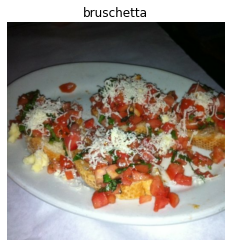

In [16]:
print("original Image")
plt.imshow(image)
plt.title(class_names[label.numpy()])
print(f"""Image shape: {image.shape} Image dtype: {image.dtype} Target class or Label from Food101 (tensor form): {label}
    Class name (str form): {class_names[label.numpy()]}""")
plt.axis(False);

original Image
Image shape: (224, 224, 3) Image dtype: <dtype: 'float32'> Target class or Label from Food101 (tensor form): 10
    Class name (str form): bruschetta


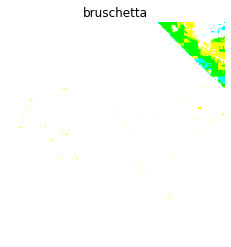

In [17]:
print("original Image")
plt.imshow(processed_image)
plt.title(class_names[processed_label.numpy()])
print(f"""Image shape: {processed_image.shape} Image dtype: {processed_image.dtype} Target class or Label from Food101 (tensor form): {processed_label}
    Class name (str form): {class_names[processed_label.numpy()]}""")
plt.axis(False);

original Image
Image shape: (224, 224, 3) Image dtype: <dtype: 'float32'> Target class or Label from Food101 (tensor form): 10
    Class name (str form): bruschetta


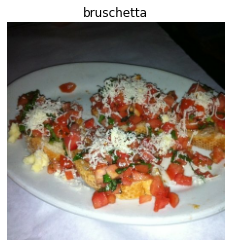

In [18]:
print("original Image")
plt.imshow(processed_image_1)
plt.title(class_names[processed_label_1.numpy()])
print(f"""Image shape: {processed_image_1.shape} Image dtype: {processed_image_1.dtype} Target class or Label from Food101 (tensor form): {processed_label_1}
    Class name (str form): {class_names[processed_label_1.numpy()]}""")
plt.axis(False);

## Creating the `train and test` dataset batches

In [19]:
train_data= train_data.map(map_func= preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
train_data= train_data.shuffle(buffer_size=1000).batch(32).prefetch(buffer_size=tf.data.AUTOTUNE) # Shuffeling the training dataset
test_data= test_data.map(map_func=preprocess_image, num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(tf.data.AUTOTUNE)

In [20]:
train_data, test_data

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

## Feature Extraction Model Callbacks

In [21]:
from helper_functions import  create_tensorboard_callback, model_check_point_callback, create_early_stopping_callback, reduce_learning_rate_callback

In [22]:
# Model Checkpoint Callback
checkpoint_feature_extraction= 'checkpoints/feature_extraction_model'
checkpoint_callback=model_check_point_callback(checkpoint_feature_extraction, save_weights_only=True, save_best_only=True, monitor="val_loss")

# Tensorboard Callback
tensorboard_callback= create_tensorboard_callback("transfer_learning", "101_classes_feature_extraction_all_data")

# Early Stopping Callback
early_stopping_callback= create_early_stopping_callback(monitor="val_accuracy", patience=5)

# Learning Rate Scheduler

def scheduler(epoch, lr):
  if epoch < 5:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

lr_scheduler_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

## Reduce Learing Rate Callback

learning_rate_reduce_callback= reduce_learning_rate_callback(monitor="val_loss", factor=0.2, patience=2, minimum_lr=1e-7)

Saving TensorBoard log files to: transfer_learning/101_classes_feature_extraction_all_data/20220817-073742


## Augmented Layer

In [23]:
augmented_layer=create_data_augmented_layer_for_model(RandomFlip="horizontal", RandomRotation=0.2, RandomZoom=0.2, RandomHeight=0.2, RandomWidth=0.2)
augmented_layer

## Turning on Mixed Precision Training

In [24]:
mixed_precision.set_global_policy("mixed_float16")

In [25]:
mixed_precision.global_policy()

<Policy "mixed_float16">

## Feature Extraction Model

In [27]:
# Create base model
input_shape = (224, 224, 3)
CLASS_COUNT= len(class_names)
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
base_model.trainable = False # freeze base model layers

# Create Functional model 
inputs = layers.Input(shape=input_shape, name="input_layer")
# Note: EfficientNetBX models have rescaling built-in but if your model didn't you could have a layer like below
# x = preprocessing.Rescaling(1./255)(x)
x= augmented_layer(inputs)
x = base_model(x, training=False) # set base_model to inference mode only
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x=  tf.keras.layers.Dropout(0.2, name="dropout_layer")(x) # Dropout Layer
x= layers.Dense(units= CLASS_COUNT,kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),bias_regularizer=regularizers.L2(1e-4), activity_regularizer=regularizers.L2(1e-5), name='regularization_layer')(x) # Regularization Layer
x = layers.Dense(CLASS_COUNT)(x) # want one output neuron per class 
# Separate activation of output layer so we can output float32 activations
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x) 
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(loss="sparse_categorical_crossentropy", # Use sparse_categorical_crossentropy when labels are *not* one-hot
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

24289280/24274472 [==============================] - 1s 0us/step


In [28]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b0 (Function  (None, None, None, 1280)  5919312  
 al)                                                             
                                                                 
 pooling_layer (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 dropout_layer (Dropout)     (None, 1280)              0         
                                                                 
 regularization_layer (Dense  (None, 101)              129381    
 )                                                               
                                                           

In [29]:
for layer in base_model.layers:
  print(layer, layer.name, layer.dtype, layer.dtype_policy)

<keras.engine.input_layer.InputLayer object at 0x7f8e631212d0> input_2 float32 <Policy "float32">
<keras.layers.preprocessing.image_preprocessing.Rescaling object at 0x7f8de80dea50> rescaling_1 float32 <Policy "mixed_float16">
<keras.layers.preprocessing.normalization.Normalization object at 0x7f8de80de3d0> normalization_1 float32 <Policy "mixed_float16">
<keras.layers.convolutional.Conv2D object at 0x7f8de80dea10> stem_conv float32 <Policy "mixed_float16">
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f8dec7cba50> stem_bn float32 <Policy "mixed_float16">
<keras.layers.core.activation.Activation object at 0x7f8de80c6790> stem_activation float32 <Policy "mixed_float16">
<keras.layers.convolutional.Conv2D object at 0x7f8ded2c5890> block1a_project_conv float32 <Policy "mixed_float16">
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f8ded2c5c50> block1a_project_bn float32 <Policy "mixed_float16">
<keras.layers.core.activatio

In [30]:
for layer in model.layers:
  print(layer, layer.name, layer.dtype, layer.dtype_policy)

<keras.engine.input_layer.InputLayer object at 0x7f8de80dee50> input_layer float32 <Policy "float32">
<keras.engine.functional.Functional object at 0x7f8decce9b10> efficientnetv2-b0 float32 <Policy "mixed_float16">
<keras.layers.pooling.GlobalAveragePooling2D object at 0x7f8dece1f190> pooling_layer float32 <Policy "mixed_float16">
<keras.layers.core.dropout.Dropout object at 0x7f8decd22b10> dropout_layer float32 <Policy "mixed_float16">
<keras.layers.core.dense.Dense object at 0x7f8dec826990> regularization_layer float32 <Policy "mixed_float16">
<keras.layers.core.dense.Dense object at 0x7f8dec896b50> dense_1 float32 <Policy "mixed_float16">
<keras.layers.core.activation.Activation object at 0x7f8decd34e90> softmax_float32 float32 <Policy "float32">


In [31]:
history_101_food_classes_feature_extract = model.fit(train_data, epochs=10,steps_per_epoch=len(train_data), validation_data=test_data, validation_steps=int(0.15 * len(test_data)),callbacks=[tensorboard_callback, checkpoint_callback, lr_scheduler_callback, learning_rate_reduce_callback])

Epoch 1/10
2368/2368 [==============================] - ETA: 0s - loss: 1.9071 - accuracy: 0.5405
Epoch 1: val_loss improved from inf to 1.29337, saving model to checkpoints/feature_extraction_model
2368/2368 [==============================] - 181s 68ms/step - loss: 1.9071 - accuracy: 0.5405 - val_loss: 1.2934 - val_accuracy: 0.6819 - lr: 0.0010
Epoch 2/10
2366/2368 [============================>.] - ETA: 0s - loss: 1.5176 - accuracy: 0.6328
Epoch 2: val_loss improved from 1.29337 to 1.22408, saving model to checkpoints/feature_extraction_model
2368/2368 [==============================] - 161s 67ms/step - loss: 1.5176 - accuracy: 0.6328 - val_loss: 1.2241 - val_accuracy: 0.7002 - lr: 0.0010
Epoch 3/10
2366/2368 [============================>.] - ETA: 0s - loss: 1.4572 - accuracy: 0.6521
Epoch 3: val_loss did not improve from 1.22408
2368/2368 [==============================] - 165s 69ms/step - loss: 1.4572 - accuracy: 0.6521 - val_loss: 1.2250 - val_accuracy: 0.7082 - lr: 0.0010
Epoch 

In [32]:
model.evaluate(test_data)

790/790 [==============================] - 47s 60ms/step - loss: 1.1669 - accuracy: 0.7271


[1.166933298110962, 0.7271286845207214]

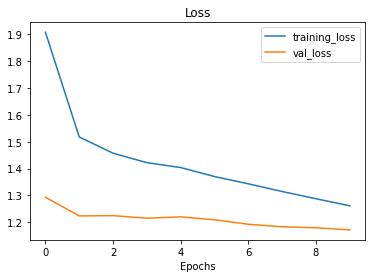

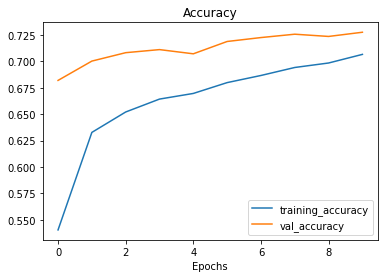

In [33]:
plot_loss_curves(history_101_food_classes_feature_extract)

In [34]:
result_feature_extraction= model.evaluate(test_data)
result_feature_extraction

790/790 [==============================] - 46s 58ms/step - loss: 1.1669 - accuracy: 0.7271


[1.166933298110962, 0.7271286845207214]

In [35]:
saved_model_dir='saved_models/model_feature_extraction_model'

In [36]:
model.save(saved_model_dir)

## Load the saved Feature Extraction Model

In [37]:
loaded_model= tf.keras.models.load_model(saved_model_dir)

In [38]:
loaded_model_result=loaded_model.evaluate(test_data)
loaded_model_result

790/790 [==============================] - 48s 59ms/step - loss: 1.1669 - accuracy: 0.7271


[1.166933298110962, 0.7271286845207214]

## Checking if the model saved/loaded correctly

In [39]:
loaded_model_result == result_feature_extraction

True

In [40]:
np.allclose(result_feature_extraction, loaded_model_result)

True

## Checking the layers of the loaded model

In [41]:
for layer in loaded_model.layers:
  print(layer, layer.name, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f8d493c7d50> input_layer True
<keras.engine.functional.Functional object at 0x7f8de8b8b350> efficientnetv2-b0 False
<keras.layers.pooling.GlobalAveragePooling2D object at 0x7f8de77f8c90> pooling_layer True
<keras.layers.core.dropout.Dropout object at 0x7f8d565cb850> dropout_layer True
<keras.layers.core.dense.Dense object at 0x7f8d56617710> regularization_layer True
<keras.layers.core.dense.Dense object at 0x7f8de8d703d0> dense_1 True
<keras.layers.core.activation.Activation object at 0x7f8de8d69d50> softmax_float32 True


In [42]:
for layer in loaded_model.layers[1].layers:
  print(layer, layer.name, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f8d56629710> input_2 True
<keras.layers.preprocessing.image_preprocessing.Rescaling object at 0x7f8de8d62c10> rescaling_1 False
<keras.layers.preprocessing.normalization.Normalization object at 0x7f8de8d62350> normalization_1 False
<keras.layers.convolutional.Conv2D object at 0x7f8de77e7a50> stem_conv False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f8d6a0e8390> stem_bn False
<keras.layers.core.activation.Activation object at 0x7f8de77e06d0> stem_activation False
<keras.layers.convolutional.Conv2D object at 0x7f8de77d5910> block1a_project_conv False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f8d6a121a50> block1a_project_bn False
<keras.layers.core.activation.Activation object at 0x7f8d56624e90> block1a_project_activation False
<keras.layers.convolutional.Conv2D object at 0x7f8de8d97e50> block2a_expand_conv False
<keras.layers.normalization.batch_normalization.Batc

## Unfreezing all the layers of the base_model i.e EfficientNetB4 for Fine-Tuning

In [43]:
for layer in loaded_model.layers:
  layer.trainable= True
  print(layer, layer.name, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f8d493c7d50> input_layer True
<keras.engine.functional.Functional object at 0x7f8de8b8b350> efficientnetv2-b0 True
<keras.layers.pooling.GlobalAveragePooling2D object at 0x7f8de77f8c90> pooling_layer True
<keras.layers.core.dropout.Dropout object at 0x7f8d565cb850> dropout_layer True
<keras.layers.core.dense.Dense object at 0x7f8d56617710> regularization_layer True
<keras.layers.core.dense.Dense object at 0x7f8de8d703d0> dense_1 True
<keras.layers.core.activation.Activation object at 0x7f8de8d69d50> softmax_float32 True


In [44]:
for layer in loaded_model.layers[1].layers:
  print(layer, layer.name, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f8d56629710> input_2 True
<keras.layers.preprocessing.image_preprocessing.Rescaling object at 0x7f8de8d62c10> rescaling_1 True
<keras.layers.preprocessing.normalization.Normalization object at 0x7f8de8d62350> normalization_1 True
<keras.layers.convolutional.Conv2D object at 0x7f8de77e7a50> stem_conv True
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f8d6a0e8390> stem_bn True
<keras.layers.core.activation.Activation object at 0x7f8de77e06d0> stem_activation True
<keras.layers.convolutional.Conv2D object at 0x7f8de77d5910> block1a_project_conv True
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f8d6a121a50> block1a_project_bn True
<keras.layers.core.activation.Activation object at 0x7f8d56624e90> block1a_project_activation True
<keras.layers.convolutional.Conv2D object at 0x7f8de8d97e50> block2a_expand_conv True
<keras.layers.normalization.batch_normalization.BatchNormaliz

In [45]:
for layer in loaded_model.layers[1].layers:
  if layer.trainable == False:
    print(layer, layer.name, layer.trainable)

In [46]:
for layer in base_model.layers:
  if layer.trainable == True:
    print(layer, layer.name)

In [47]:
len(loaded_model.layers)

7

In [48]:
len(loaded_model.trainable_variables)

245

In [49]:
len(base_model.trainable_variables)

0

In [50]:
len(base_model.layers)

255

## Callback for Fine-Tuning All unfrozen layers

In [51]:
checpoint_fine_tuning= "checkpoints_fine_tuning_all"

checkpoint_callback_fine_tuning_all_unfrozen=model_check_point_callback(checpoint_fine_tuning, save_weights_only=True, save_best_only=True, monitor="val_accuracy")
tensorboard_callback_fine_tuning_all_unfrozen= create_tensorboard_callback("transfer_learning", "101_classes_fine_tuning_all_data_all_unfrozen_layers")
early_stopping_callback_fine_tuning_all_unfrozen= create_early_stopping_callback(monitor="val_loss", patience=5)
learning_rate_reduce_callback_all_unfrozen= reduce_learning_rate_callback(monitor="val_loss", factor=0.2, patience=2, minimum_lr=1e-7)

Saving TensorBoard log files to: transfer_learning/101_classes_fine_tuning_all_data_all_unfrozen_layers/20220817-081351


In [52]:
loaded_model.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=["accuracy"])

In [53]:
history_fine_tuned_all= loaded_model.fit(train_data, epochs=100, steps_per_epoch=len(train_data) ,validation_data= test_data, validation_steps=int(0.15 * len(test_data)), callbacks=[checkpoint_callback_fine_tuning_all_unfrozen, tensorboard_callback_fine_tuning_all_unfrozen, early_stopping_callback_fine_tuning_all_unfrozen, learning_rate_reduce_callback_all_unfrozen])

Epoch 1/100
2368/2368 [==============================] - ETA: 0s - loss: 1.1179 - accuracy: 0.7447
Epoch 1: val_accuracy improved from -inf to 0.78814, saving model to checkpoints_fine_tuning_all
2368/2368 [==============================] - 293s 115ms/step - loss: 1.1179 - accuracy: 0.7447 - val_loss: 0.9248 - val_accuracy: 0.7881 - lr: 1.0000e-04
Epoch 2/100
2368/2368 [==============================] - ETA: 0s - loss: 0.7845 - accuracy: 0.8287
Epoch 2: val_accuracy improved from 0.78814 to 0.80959, saving model to checkpoints_fine_tuning_all
2368/2368 [==============================] - 280s 118ms/step - loss: 0.7845 - accuracy: 0.8287 - val_loss: 0.8550 - val_accuracy: 0.8096 - lr: 1.0000e-04
Epoch 3/100
2367/2368 [============================>.] - ETA: 0s - loss: 0.5624 - accuracy: 0.8850
Epoch 3: val_accuracy improved from 0.80959 to 0.82124, saving model to checkpoints_fine_tuning_all
2368/2368 [==============================] - 276s 116ms/step - loss: 0.5624 - accuracy: 0.8850 - v

In [54]:
loaded_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b0 (Function  (None, None, None, 1280)  5919312  
 al)                                                             
                                                                 
 pooling_layer (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 dropout_layer (Dropout)     (None, 1280)              0         
                                                                 
 regularization_layer (Dense  (None, 101)              129381    
 )                                                               
                                                           

In [55]:
result_loaded_model_2=loaded_model.evaluate(test_data)
result_loaded_model_2

790/790 [==============================] - 47s 59ms/step - loss: 0.9460 - accuracy: 0.8297


[0.9459918737411499, 0.8297029733657837]

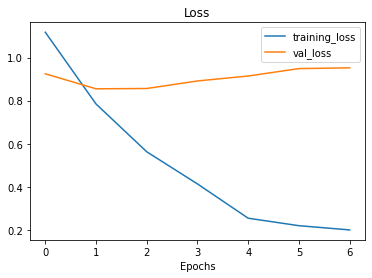

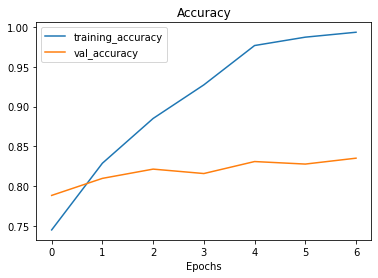

In [56]:
plot_loss_curves(history_fine_tuned_all)

## Evaluating `loaded_model`

In [57]:
pred_probs=loaded_model.predict(test_data, verbose=1)

790/790 [==============================] - 47s 57ms/step


In [58]:
pred_classes= pred_probs.argmax(axis=1)

pred_classes[:5]

array([29, 81, 91, 53, 97])

In [59]:
y_labels = []
test_images = []
for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy())
y_labels[:10]

[29, 81, 91, 53, 97, 97, 10, 31, 3, 100]

## Accuracy Score

In [60]:
sklearn_accuracy= accuracy_score(y_true= y_labels, y_pred= pred_classes)
sklearn_accuracy

0.8297029702970297

## Confusion Matrix

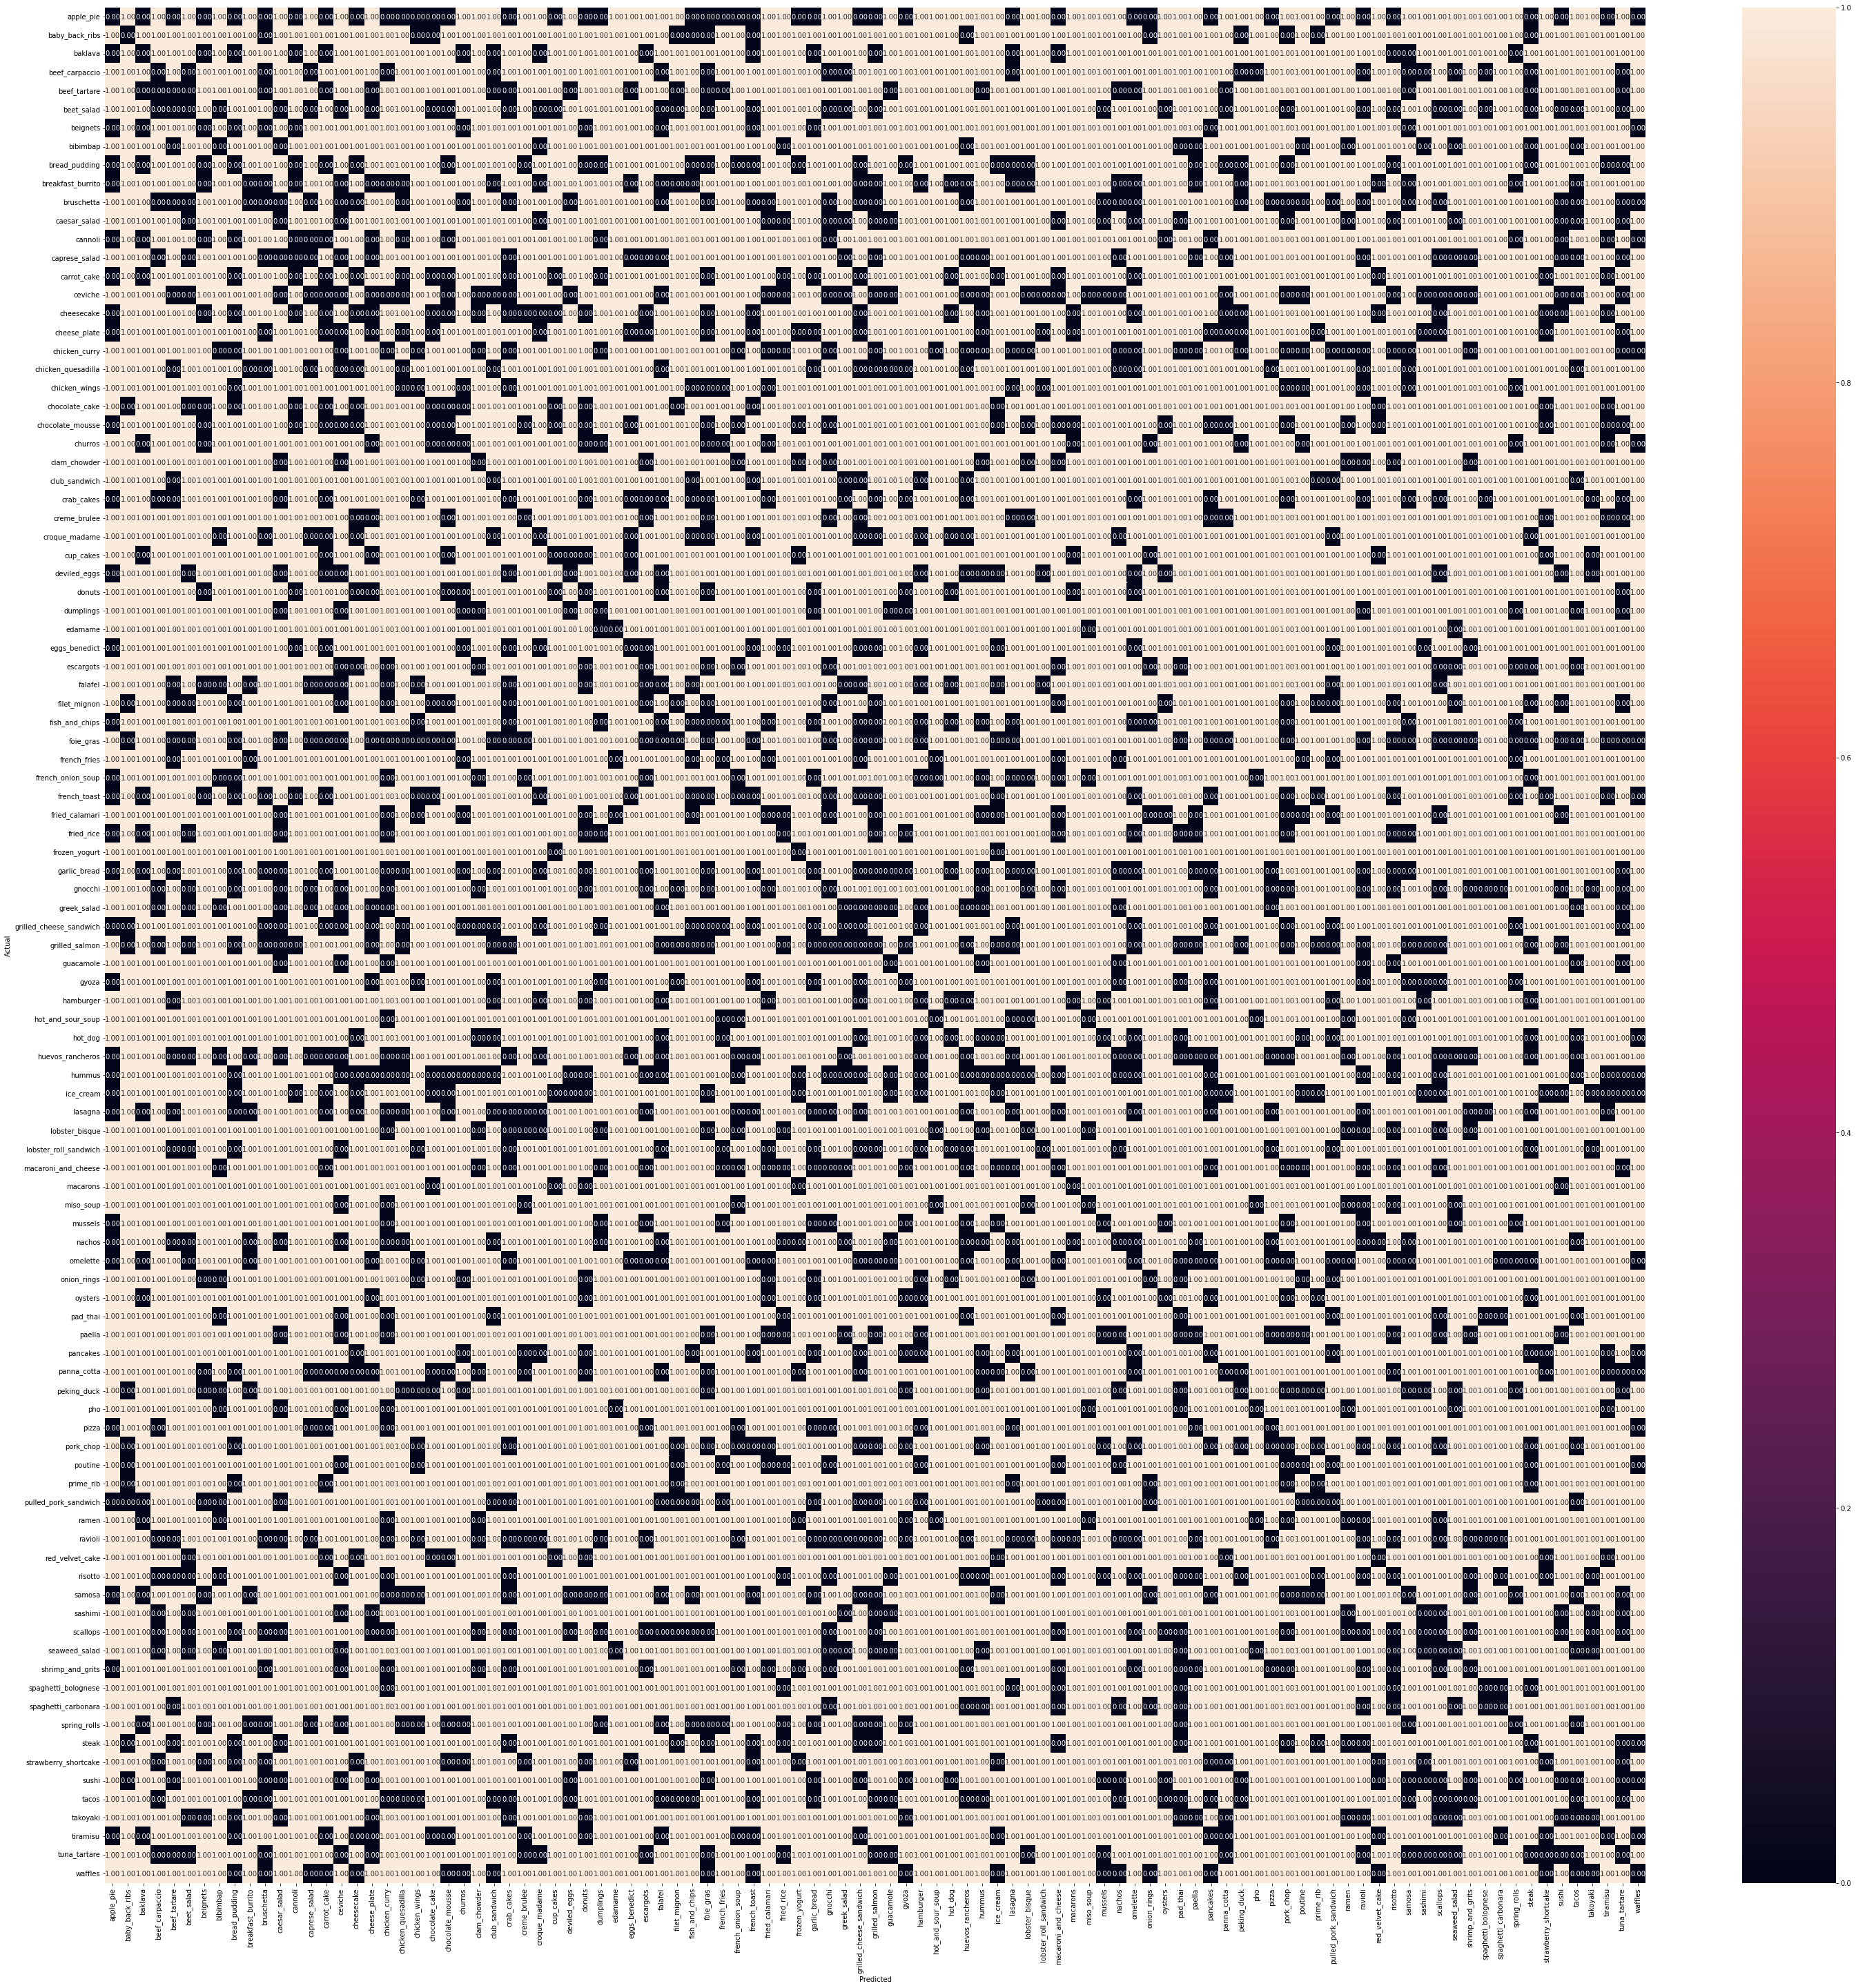

In [61]:
cm = confusion_matrix(y_labels, pred_classes)
# Normalise
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]==0
fig, ax = plt.subplots(figsize=(50,50))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=class_names, yticklabels=class_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

## Classification Report 

In [62]:
print(classification_report(y_true= y_labels, y_pred= pred_classes))

              precision    recall  f1-score   support

           0       0.67      0.64      0.65       250
           1       0.86      0.81      0.83       250
           2       0.88      0.86      0.87       250
           3       0.88      0.85      0.87       250
           4       0.79      0.79      0.79       250
           5       0.76      0.72      0.74       250
           6       0.85      0.89      0.87       250
           7       0.92      0.93      0.92       250
           8       0.66      0.66      0.66       250
           9       0.82      0.72      0.77       250
          10       0.84      0.76      0.80       250
          11       0.81      0.88      0.84       250
          12       0.91      0.89      0.90       250
          13       0.84      0.84      0.84       250
          14       0.75      0.80      0.78       250
          15       0.76      0.71      0.73       250
          16       0.70      0.69      0.70       250
          17       0.85    

In [63]:
classification_report_dict= classification_report(y_labels, pred_classes, output_dict=True)
classification_report_dict

{'0': {'precision': 0.6666666666666666,
  'recall': 0.64,
  'f1-score': 0.6530612244897959,
  'support': 250},
 '1': {'precision': 0.8632478632478633,
  'recall': 0.808,
  'f1-score': 0.8347107438016529,
  'support': 250},
 '2': {'precision': 0.8816326530612245,
  'recall': 0.864,
  'f1-score': 0.8727272727272728,
  'support': 250},
 '3': {'precision': 0.8801652892561983,
  'recall': 0.852,
  'f1-score': 0.8658536585365854,
  'support': 250},
 '4': {'precision': 0.7857142857142857,
  'recall': 0.792,
  'f1-score': 0.7888446215139442,
  'support': 250},
 '5': {'precision': 0.7573221757322176,
  'recall': 0.724,
  'f1-score': 0.7402862985685071,
  'support': 250},
 '6': {'precision': 0.8479087452471483,
  'recall': 0.892,
  'f1-score': 0.8693957115009747,
  'support': 250},
 '7': {'precision': 0.9173228346456693,
  'recall': 0.932,
  'f1-score': 0.9246031746031745,
  'support': 250},
 '8': {'precision': 0.6586345381526104,
  'recall': 0.656,
  'f1-score': 0.6573146292585171,
  'support':

## Visualizing the F1-score

In [64]:
class_f1_scores= {}

# Looping through the classification report dictionary items
for k, v in classification_report_dict.items():
  if k == "accuracy":
    break

  else:
    class_f1_scores[class_names[int(k)]] = v["f1-score"]


class_f1_scores

{'apple_pie': 0.6530612244897959,
 'baby_back_ribs': 0.8347107438016529,
 'baklava': 0.8727272727272728,
 'beef_carpaccio': 0.8658536585365854,
 'beef_tartare': 0.7888446215139442,
 'beet_salad': 0.7402862985685071,
 'beignets': 0.8693957115009747,
 'bibimbap': 0.9246031746031745,
 'bread_pudding': 0.6573146292585171,
 'breakfast_burrito': 0.7702127659574468,
 'bruschetta': 0.8,
 'caesar_salad': 0.8413001912045889,
 'cannoli': 0.8991935483870968,
 'caprese_salad': 0.8383233532934131,
 'carrot_cake': 0.7766990291262137,
 'ceviche': 0.731404958677686,
 'cheesecake': 0.6975806451612903,
 'cheese_plate': 0.8649706457925637,
 'chicken_curry': 0.7820773930753564,
 'chicken_quesadilla': 0.8232931726907632,
 'chicken_wings': 0.8832684824902725,
 'chocolate_cake': 0.7677165354330708,
 'chocolate_mousse': 0.6745562130177515,
 'churros': 0.8982035928143712,
 'clam_chowder': 0.8814229249011858,
 'club_sandwich': 0.874751491053678,
 'crab_cakes': 0.7324478178368122,
 'creme_brulee': 0.904,
 'croque

In [65]:
f1_scores= pd.DataFrame({"class_names": list(class_f1_scores.keys()), "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)

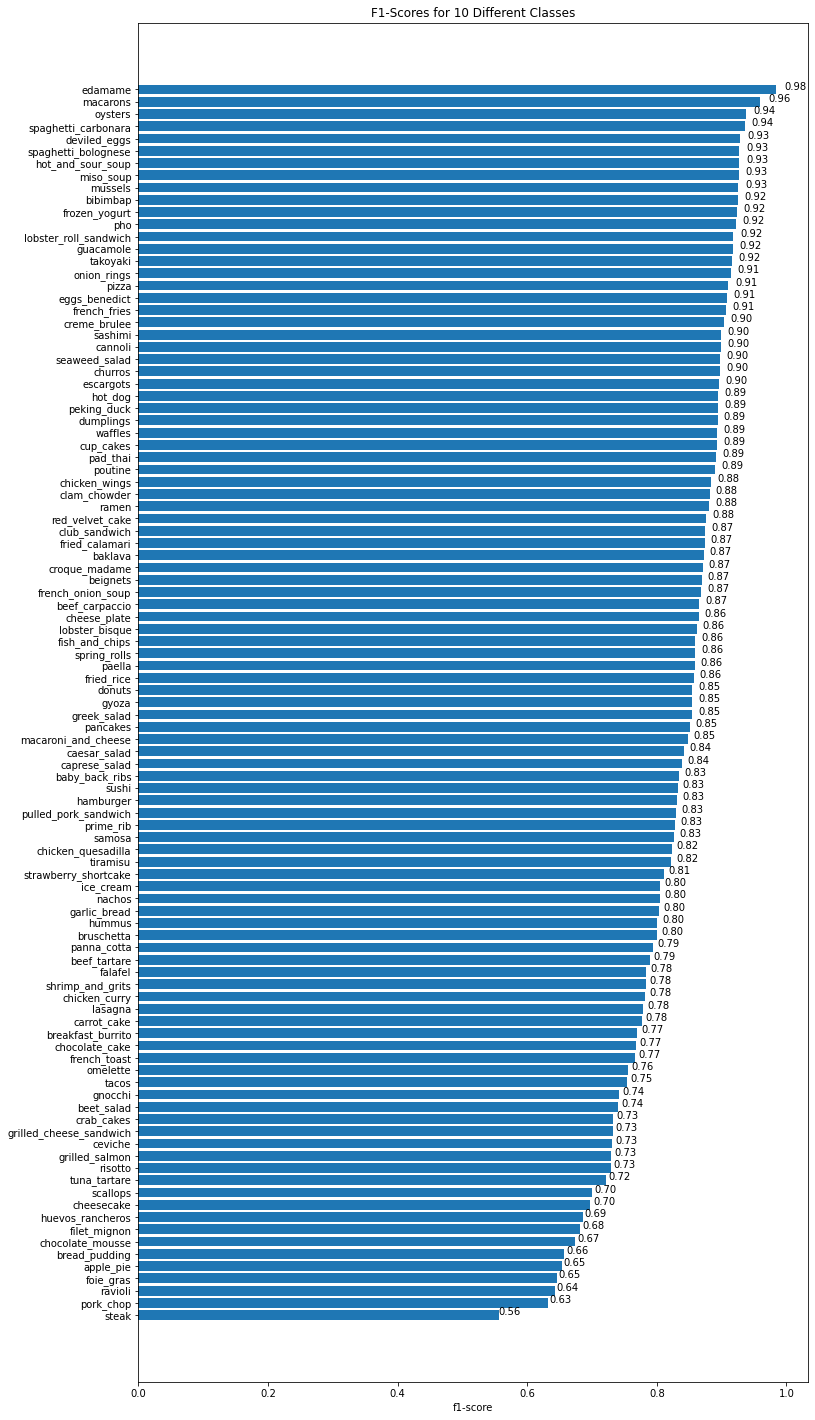

In [66]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(list(f1_scores["class_names"]))
ax.set_xlabel("f1-score")
ax.set_title("F1-Scores for 10 Different Classes")
ax.invert_yaxis(); # reverse the order

def autolabel(rects): # Modified version of: https://matplotlib.org/examples/api/barchart_demo.html
  """
  Attach a text label above each bar displaying its height (it's value).
  """
  for rect in rects:
    width = rect.get_width()
    ax.text(1.03*width, rect.get_y() + rect.get_height()/1.5,
            f"{width:.2f}",
            ha='center', va='bottom')

autolabel(scores)

## Tensorboard

In [ ]:
!tensorboard dev upload --logdir ./transfer_learning \
--name "Transfer Learning on the Food101 dataset with EfficientNetB4" \
--description "Training a Transfer Learning model with EfficientNetB4 to beat the DeepFood paper which is based on the Food101 dataset." \
--one_shot

### Tensorboard Link 

Link -> https://tensorboard.dev/experiment/btYndH3jQrmKFWuvJnQ3RA/

In [ ]:
!tensorboard dev list

## Evaluating on custom dataset

In [67]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip

--2022-08-17 08:53:29--  https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.10.128, 142.251.12.128, 172.217.194.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.10.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13192985 (13M) [application/zip]
Saving to: ‘custom_food_images.zip’

custom_food_images. 100%[===================>]  12.58M  23.3MB/s    in 0.5s    

2022-08-17 08:53:30 (23.3 MB/s) - ‘custom_food_images.zip’ saved [13192985/13192985]



In [68]:
unzip_data('custom_food_images.zip')

In [69]:
custom_food_images = ["custom_food_images/" + img_path for img_path in os.listdir("custom_food_images")]
custom_food_images

['custom_food_images/pizza-dad.jpeg',
 'custom_food_images/chicken_wings.jpeg',
 'custom_food_images/steak.jpeg',
 'custom_food_images/sushi.jpeg',
 'custom_food_images/ramen.jpeg',
 'custom_food_images/hamburger.jpeg']

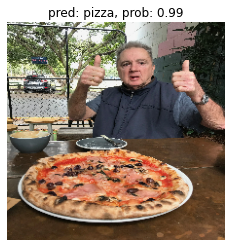

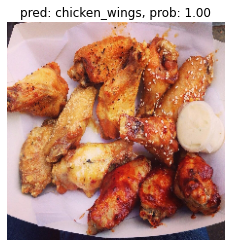

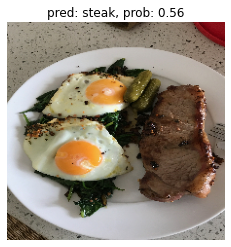

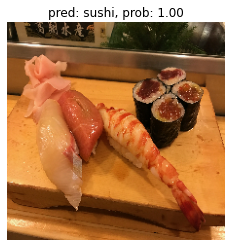

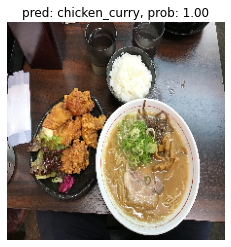

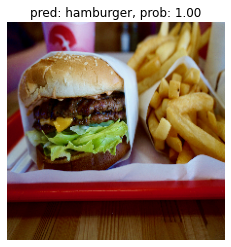

In [70]:
for img in custom_food_images:
  img = load_and_prep_image(img, scale=False) # load in target image and turn it into tensor
  pred_prob = loaded_model.predict(tf.expand_dims(img, axis=0)) # make prediction on image with shape [None, 224, 224, 3]
  pred_class = class_names[pred_prob.argmax()] # find the predicted class label
  # Plot the image with appropriate annotations
  plt.figure()
  plt.imshow(img/255.) # imshow() requires float inputs to be normalized
  plt.title(f"pred: {pred_class}, prob: {pred_prob.max():.2f}")
  plt.axis(False)